In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.9 MB/s eta 0:00:00:00:0100:01


In [1]:
import os.path as osp
import time

import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

In [2]:
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader


from torch_geometric.nn import GATConv



In [7]:
#ppi_dataset = PPI(root='./ppi_data/')

In [8]:
ppi_dataset = PPI(root='./ppi_data/')

In [9]:
path = './ppi_data/'

In [10]:
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [11]:
train_dataset.num_classes

121

In [12]:
train_dataset.print_summary()

PPI (#graphs=20):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |   2245.3 |  61318.4 |
| std        |    766.2 |  28601.2 |
| min        |    591   |   7708   |
| quantile25 |   1806   |  42288   |
| median     |   2326   |  59862   |
| quantile75 |   2799.2 |  85368.5 |
| max        |   3480   | 106754   |
+------------+----------+----------+


In [13]:
train_dataset.num_node_features

50

In [14]:
train_dataset.data.x.shape

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


torch.Size([44906, 50])

In [15]:
train_dataset.data.x.shape

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


torch.Size([44906, 50])

In [16]:
train_dataset.data.edge_index.shape

torch.Size([2, 1226368])

In [17]:
train_dataset.data.y.shape

torch.Size([44906, 121])

In [18]:
class GATPPI(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(train_dataset.num_features, 256, heads=4)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * 256)
        self.conv2 = GATConv(4 * 256, 256, heads=4)
        self.lin2 = torch.nn.Linear(4 * 256, 4 * 256)
        self.conv3 = GATConv(4 * 256, train_dataset.num_classes, heads=6,
                             concat=False)
        self.lin3 = torch.nn.Linear(4 * 256, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATPPI().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [20]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)

In [21]:
@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

In [22]:
test(test_loader)

0.36469439712103513

In [23]:
def calculate_val_loss():
    model.eval()
    total_val_loss = 0
    for data in val_loader:
        data = data.to(device)
        val_loss = loss_op(model(data.x, data.edge_index), data.y)
        total_val_loss += val_loss.item() * data.num_graphs
    return total_val_loss / len(val_loader.dataset)

In [24]:
import time

In [25]:
times = []

In [26]:
# Placeholder for training and validation losses
train_losses = []
val_losses = []

# Main training and evaluation loop
for epoch in range(1, 101):
    start = time.time()
    
    train_loss = train()
    train_losses.append(train_loss)
    
    val_loss = calculate_val_loss()
    val_losses.append(val_loss)
    
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    
    end = time.time()
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
    times.append(end - start)




Epoch: 001, Loss: 0.8840, Val Loss: 0.5602, Val F1: 0.4854
Epoch: 002, Loss: 0.5341, Val Loss: 0.5031, Val F1: 0.5523
Epoch: 003, Loss: 0.4864, Val Loss: 0.4630, Val F1: 0.5588
Epoch: 004, Loss: 0.4459, Val Loss: 0.4382, Val F1: 0.6169
Epoch: 005, Loss: 0.4148, Val Loss: 0.4079, Val F1: 0.6671
Epoch: 006, Loss: 0.3708, Val Loss: 0.3768, Val F1: 0.7109
Epoch: 007, Loss: 0.3298, Val Loss: 0.3417, Val F1: 0.7489
Epoch: 008, Loss: 0.2896, Val Loss: 0.3051, Val F1: 0.7773
Epoch: 009, Loss: 0.2453, Val Loss: 0.2741, Val F1: 0.8073
Epoch: 010, Loss: 0.2187, Val Loss: 0.2527, Val F1: 0.8234
Epoch: 011, Loss: 0.1912, Val Loss: 0.2136, Val F1: 0.8569
Epoch: 012, Loss: 0.1591, Val Loss: 0.1952, Val F1: 0.8721
Epoch: 013, Loss: 0.1355, Val Loss: 0.1708, Val F1: 0.8952
Epoch: 014, Loss: 0.1200, Val Loss: 0.1623, Val F1: 0.9005
Epoch: 015, Loss: 0.1043, Val Loss: 0.1447, Val F1: 0.9160
Epoch: 016, Loss: 0.0847, Val Loss: 0.1342, Val F1: 0.9225
Epoch: 017, Loss: 0.0780, Val Loss: 0.1292, Val F1: 0.92

In [27]:
import matplotlib.pyplot as plt

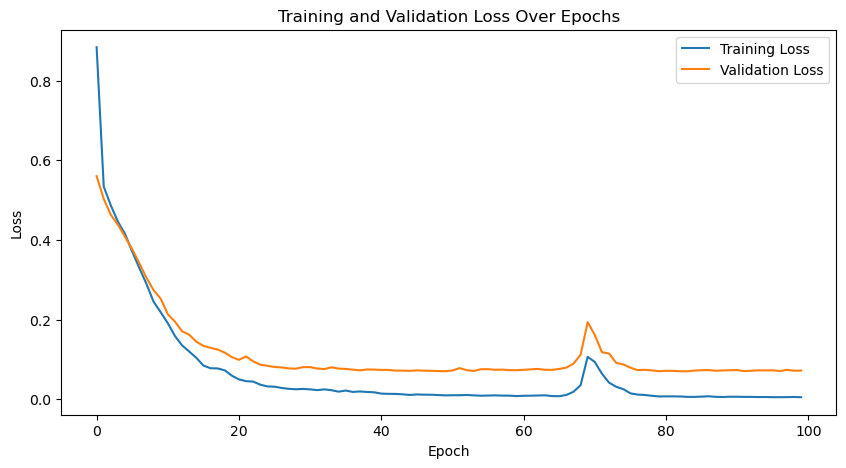

In [29]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [30]:
test(test_loader)

0.9876962537697757

In [31]:
!nvidia-smi

Sat Dec  9 04:29:15 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A10G                    On  | 00000000:00:1E.0 Off |                    0 |
|  0%   20C    P0              56W / 300W |   8060MiB / 23028MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--